### Independent group analysis
#### Our group include 3 students:
- Urban Halpern
- James Phan
- Quang Loc Lam

#### Hypothesis 1 (Quang Loc Lam): 

- H0: There is no difference between the means of procedure lengths of patients having both COVID-19 and diabetes and patients having only COVID-19.
- H1: There is a difference between the means of procedure lengths of patients having both COVID-19 and diabetes and patients having only COVID-19.

##### Motivation of our hypothesis: 
We think that patients who have diabetes will need more time to recover from COVID-19 than patients how only have COVID-19, because diabetes can lengthen recovery time from illnesses due to its impact on blood circulation, immune function, and wound healing. As a result, the procedure lengths of patients who have both diabetes and COVID-19 may be longer than the procedure lengths of patients who have only COVID-19.

#### Value:

Our research can provide valuable insights for healthcare providers to better manage and anticipate the needs of diabetic patients with COVID-19. Moreover, it helps the hospitals and healthcare providers estimate the extended procedure time that patients with diabetes and COVID-19 need, so they can allocate the resources better.

#### Methodology

We collect the procedure lengths of two groups of patients:
- Patients who have both diabetes and COVID-19. 
- Patients who have only COVID-19.

Then we draw the Box Plots and run the t-test to compare the means of procedure lenths of two groups.

#### Read the Parquet file

In [0]:
# Step 1: Set the path to the Parquet file
parquet_file_path = "dbfs:/FileStore/data/medical_records.parquet"

# Step 2: Read the Parquet file into a DataFrame
df = spark.read.parquet(parquet_file_path)

# Step 3: Show the DataFrame contents
df.show()

# Step 4: Display the DataFrame schema
df.printSchema()

+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|        demographics|           encounter|          conditions|         medications|       immunizations|              vitals|          laboratory|          procedures|
+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|{{Boston, Massach...|{2020-03-18, 3278...|[{49727002, Cough...|[{854235, 0.4 ML ...|                  []|{null, {{{8462-4,...|{{94531-1, SARS-C...|[{261352009, 2020...|
|{{Chelsea, Massac...|{2020-05-22, 2a45...|[{49727002, Cough...|                  []|[{140, 2020-05-22...|{{2020-05-22, {83...|{{94531-1, SARS-C...|[{261352009, 2020...|
|{{Boston, Massach...|{2020-03-28, a169...|[{49727002, Cough...|[{854235, 0.4 ML ...|                  []|{null, {{{8462-4,...|{{94531-1, SARS-C...|[{

In [0]:
from pyspark.sql.functions import size, col 

procedure_length = df.withColumn("procedure_length", size(col("procedures")))
procedure_length.select("procedures", "procedure_length").take(1)

Out[36]: [Row(procedures=[Row(code='261352009', date='2020-03-02', description='Face mask (physical object)', reasonCode='840544004', reasonDescription='Suspected COVID-19'), Row(code='399208008', date='2020-03-02', description='Plain chest X-ray (procedure)', reasonCode='', reasonDescription=''), Row(code='371908008', date='2020-03-02', description='Oxygen administration by mask (procedure)', reasonCode='389087006', reasonDescription='Hypoxemia (disorder)'), Row(code='431182000', date='2020-03-02', description='Placing subject in prone position (procedure)', reasonCode='389087006', reasonDescription='Hypoxemia (disorder)'), Row(code='371908008', date='2020-03-03', description='Oxygen administration by mask (procedure)', reasonCode='389087006', reasonDescription='Hypoxemia (disorder)'), Row(code='431182000', date='2020-03-03', description='Placing subject in prone position (procedure)', reasonCode='389087006', reasonDescription='Hypoxemia (disorder)'), Row(code='371908008', date='2020-

##### Calculate the number of patients having both COVID-19 and diabetes:

In [0]:
from pyspark.sql.functions import expr

# Filter patients with both COVID-19 and Diabetes
both = procedure_length.filter(
    expr("exists(conditions, x -> x.description = 'COVID-19')") & 
    expr("exists(conditions, x -> LOWER(x.description) LIKE '%diabetes%')")
)

# Count the number of matching rows
count_both = both.count()
print(f"Number of patients with both COVID-19 and diabetes: {count_both}")


Number of patients with both COVID-19 and diabetes: 5


##### Calculate the number of patients who have COVID-19 but do not have diabetes:

In [0]:
from pyspark.sql.functions import expr

# Filter patients with only COVID-19 (without diabetes)
only_covid = procedure_length.filter(
    expr("exists(conditions, x -> x.description = 'COVID-19')") & 
    ~expr("exists(conditions, x -> LOWER(x.description) LIKE 'diabetes')")
)

# Count the number of matching rows
count_only_covid = only_covid.count()
print(f"Number of patients with only COVID-19 (no diabetes): {count_only_covid}")


Number of patients with only COVID-19 (no diabetes): 1435


##### Collect the procedure lengths of patients who have both COVID-19 and diabetes:

In [0]:

both_counts = both.select("procedure_length").collect()
both_counts_list = [row['procedure_length'] for row in both_counts]
both_counts_list[0:20]

Out[39]: [1, 26, 2, 34, 17]

##### Collect the procedure lengths of patients who have only COVID-19:

In [0]:
only_covid_counts = only_covid.select("procedure_length").collect()
only_covid_counts_list = [row['procedure_length'] for row in only_covid_counts]
only_covid_counts_list[0:20]

Out[40]: [16, 1, 12, 56, 1, 1, 1, 1, 1, 1, 1, 42, 1, 2, 19, 2, 3, 1, 32, 1]

##### Draw Box Plots to compare the procedure lengths of patients who have both diabetes and COVID-19 and the procedure lengths of patients who have only COVID-19.

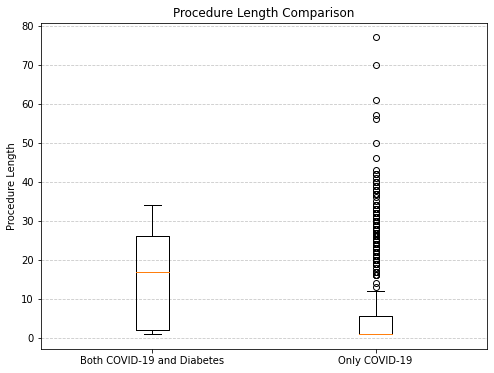

In [0]:
# Re-import necessary libraries
import matplotlib.pyplot as plt

# Create box plots
plt.figure(figsize=(8, 6))
plt.boxplot([both_counts_list, only_covid_counts_list], labels=['Both COVID-19 and Diabetes', 'Only COVID-19'])

# Customize the plot
plt.title('Procedure Length Comparison')
plt.ylabel('Procedure Length')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


##### Run t-test to check if there is a difference between the means of procedure lengths of two groups of patients.

In [0]:
# Import necessary libraries
import pandas as pd
from scipy import stats


# Run t-test to compare the means
t_stat, p_value = stats.ttest_ind(both_counts_list, only_covid_counts_list, equal_var=False)

# Display results
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpret the result
if p_value < 0.05:
    print("With 95% confidence, there is a statistically significant difference between the means of procedure lengths of two groups.")
else:
    if p_value < 0.1:
        print("With 90% confidence, there is a statistically significant difference between the means of procedure lengths of two groups.")
    else:
        print("There is no statistically significant difference between the means of procedure lengths of two groups.")


T-statistic: 1.31
P-value: 0.2608
There is no statistically significant difference between the means of procedure lengths of two groups.


#### Conclusion: 
- Because p-value = 0.26 > 0.05, we cannot reject H0 with 95% confidence. 
- It means that with 95% confidence, there is no evidence that there is a difference between the procedure lengths of two groups of patients.
- However, the Box Plot shows that with respect to central tendency, the median of procedure lengths of patients who have both COVID-19 and diabetes is higher than the median of procedure lengths of patients who have only COVID-19. The doctors and healthcare providers still need to pay an attention on that.
- The group of patients having both COVID-19 and diabetes has a very small sample size (n=5). It may affect the results of the statistical test.

### Hypothesis 2: (Quang Loc Lam) 

- H0: There is no difference between the procedure lenghts of patients having both COVID-19 and fever and the procedure lengths of patients having only COVID-19.
- H1: The procedure lenghts of patients having both COVID-19 and fever are longer than the procedure lengths of patients having only COVID-19.

##### Motivation of our hypothesis: 
The reason for this hypothesis is that having fever is associated with more serious infection. As a result, it can make the patient to have a longer procedure.

##### Value:
This study will help doctors and healthcare providers allocate resources better if the COVID-19 patients need extra procedure lengths.

##### Methodology:
We collect the procedure lenths of two groups of patients:
- Patients having both COVID-19 and fever.
- Patients having only COVID-19.

Then we draw the Box Plots and run the t-test to see if there is a difference in the procedure lengths of two groups.

##### Calculate the number of patients and the percentages

In [0]:
from pyspark.sql.functions import expr

# Filter records with 'Fever'
fever_df = df.filter(
    expr("exists(conditions, x -> LOWER(x.description) LIKE '%fever%')")
)

# Filter records with 'COVID-19'
covid_df = df.filter(
    expr("exists(conditions, x -> x.description = 'COVID-19')")
)

# Filter records with both 'Fever' and 'COVID-19'
fever_covid_df = df.filter(
    expr("exists(conditions, x -> LOWER(x.description) LIKE '%fever%')") & 
    expr("exists(conditions, x -> x.description = 'COVID-19')")
)

# Count occurrences
total_fever = fever_df.count()
total_covid = covid_df.count()
total_both = fever_covid_df.count()

# Calculate conditional probabilities
if total_covid > 0:
    p_fever_given_covid = (total_both / total_covid) * 100
    print(f"Percentage of COVID-19 patients with Fever: {p_fever_given_covid:.2f}%")

if total_fever > 0:
    p_covid_given_fever = (total_both / total_fever) * 100
    print(f"Percentage of Fever patients with COVID-19: {p_covid_given_fever:.2f}%")

# Print raw counts for reference
print(f"Total with Fever: {total_fever}")
print(f"Total with COVID-19: {total_covid}")
print(f"Total with both Fever and COVID-19: {total_both}")


Percentage of COVID-19 patients with Fever: 89.27%
Percentage of Fever patients with COVID-19: 96.90%
Total with Fever: 1322
Total with COVID-19: 1435
Total with both Fever and COVID-19: 1281


In [0]:
from pyspark.sql.functions import expr

# Filter patients with only COVID-19 (without fever)
only_covid = procedure_length.filter(
    expr("exists(conditions, x -> x.description = 'COVID-19')") & 
    ~expr("exists(conditions, x -> LOWER(x.description) LIKE '%fever%')")
)

# Count the number of matching rows
count_only_covid = only_covid.count()
print(f"Number of patients with only COVID-19 (no fever): {count_only_covid}")


# Filter patients with only fever (without COVID-19)
only_fever = procedure_length.filter(
    expr("exists(conditions, x -> LOWER(x.description) LIKE '%fever%')") & 
    ~expr("exists(conditions, x -> x.description = 'COVID-19')")
)

# Count the number of matching rows
count_only_fever = only_fever.count()
print(f"Number of patients with only fever (no COVID-19): {count_only_fever}")

# Filter patients with COVID-19 and fever
both_covid_fever = procedure_length.filter(
    expr("exists(conditions, x -> x.description = 'COVID-19')") & 
    expr("exists(conditions, x -> LOWER(x.description) LIKE '%fever%')"))

# Count the number of matching rows
count_both_covid_fever = both_covid_fever.count()
print(f"Number of patients with COVID-19 and fever: {count_both_covid_fever}")


Number of patients with only COVID-19 (no fever): 154
Number of patients with only fever (no COVID-19): 41
Number of patients with COVID-19 and fever: 1281


##### Collect the procedure lengths of patients having both COVID-19 and fever

In [0]:
both_counts = both_covid_fever.select("procedure_length").collect()
both_counts_list = [row['procedure_length'] for row in both_counts]
both_counts_list[0:20]

Out[46]: [16, 1, 12, 56, 1, 1, 1, 1, 1, 1, 1, 42, 1, 2, 19, 2, 3, 1, 32, 1]

##### Collect the procedure lengths of patients having only COVID-19

In [0]:
only_covid_counts = only_covid.select("procedure_length").collect()
only_covid_counts_list = [row['procedure_length'] for row in only_covid_counts]
only_covid_counts_list[0:20]

Out[47]: [3, 1, 1, 4, 33, 26, 4, 20, 31, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 8]

##### Draw Box Plots to compare the procedure lengths of these patients

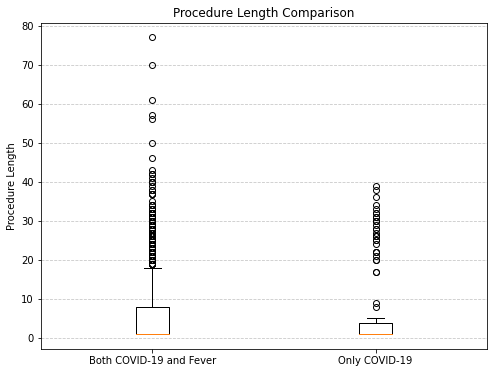

In [0]:
# Re-import necessary libraries
import matplotlib.pyplot as plt

# Create box plots
plt.figure(figsize=(8, 6))
plt.boxplot([both_counts_list, only_covid_counts_list], labels=['Both COVID-19 and Fever', 'Only COVID-19'])

# Customize the plot
plt.title('Procedure Length Comparison')
plt.ylabel('Procedure Length')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

##### Run t-test to see if there is a difference between the means of procedure lengths of two groups

In [0]:
# Import necessary libraries
import pandas as pd
from scipy import stats

# Perform independent t-test
t_stat, p_value = stats.ttest_ind(both_counts_list, only_covid_counts_list, equal_var=False)

# Display the results
print(f"T-statistic: {t_stat:.2f}")
print(f"P-value: {p_value:.4f}")

# Interpret the result
if p_value < 0.05:
    print("With 95% confidence, there is a statistically significant difference between the procedure lengths of two groups.")
else:
    if p_value < 0.1:
        print("With 90% confidence, there is a statistically significant difference between the procedure lengths of two groups.")
    else:
        print("There is no statistically significant difference between the procedure lengths of two groups.")


T-statistic: 1.11
P-value: 0.2664
There is no statistically significant difference between the procedure lengths of two groups.


###### Conclusion

- Because p-value = 0.2664 > 0.05, we cannot reject the H0 hypothesis with 95% confidence.
- In other words, there is no evidence that there is a difference between the procedure lengths of of patients having both COVID-19 and fever and the procedure lengths of patients having only COVID-19 with 95% confidence.
- The Box Plots show  that the medians of procedure lengths of two groups of patients are the same.
- Therefore, we can conclude that having fever does not make a COVID-19 patient to have a longer procedure length, with 95% confidence.
- An explanation for this result is that having fever means that a patient has more serious infection. However, the difference in infection is not strong enough to make the patient to have a longer procedure.